In [1]:
import findspark
import pyspark
import matplotlib.pyplot as plt
from pyspark.sql import SQLContext
from pyspark.sql import Row
from pyspark.sql import SparkSession
from pyspark.sql.types import FloatType
from pyspark.sql.functions import regexp_replace
from pyspark.sql import functions as sf
import folium
import json
import seaborn as sns
from scipy.stats import pearsonr
from functools import reduce

# Voorbereiding opstart verwerking

We definiëren eerst een aantal constanten waar we verder in onze verwerking naar kunnen refereren.

In [2]:
JAAR_VERWERKING = 2021    # Mogelijke optimalisatie: interactief bepalen via Widget

Gemeentes zijn niet consistent tussen de data-sets (omwille van fusie-probklematiek).
Volgende gemeentes staan in de CSV files op gemeente niveau maar zijn niet terug gevonden in de TopoJSON gemeente_fusies.json.
* Beveren-Kruibeke-Zwijndrecht  (allen apart aanwezig in TopoJSON)
* Bilzen-Hoeselt  (beiden apart aanwezig in TopoJSON)
* Merelbeke-Melle   (beiden apart aanwezig in TopoJSON)
* Nazareth-De Pinte   (beiden apart aanwezig in TopoJSON)
* Pajottegem (NIET aanwezig in TopoJSON)
* Tessenderlo-Ham   (beiden apart aanwezig in TopoJSON)
* Tongeren-Borgloon  (beiden apart aanwezig in TopoJSON)
* Vlaams Gewest   (niet relevant)

Dit betekent dat we een Data-set van de CSV files moeten maken waarin elk van de fusie-gemeentes apart worden aangemaakt en de data krijgen van de fusiegemeente. Bijvoorbeeld: het data-record met gemeente 'Bilzen-Hoeselt' zal uiteen vallen in 2 records: Bilzen en Hoeselt.

Als we dit corrigeren zijn er nog resterende anomalieën tussen de csv-data file en de TopoJSON:
* Borsbeek (niet toonbaar - geen gegevens in csv data-sets)
  * Geen data gevonden in de csv data-sets
  * Oplossing: geen
* Brussel + gemeenten die tot Brussel behoren (niet toonbaar - geen gegevens in csv data-sets)
  * Oplossing: geen
* Pajottegem (niet toonbaar - geen gegevens in csv data-sets)
  * Ontstaan uit fusie van Galmaarden, Gooik en Herne
  * Pajottegem niet in csv data-sets
  * Pajottegem wel in TopoJSON
  * Galmaarden staat niet in csv data-sets
  * Gooik staat niet in csv data-sets
  * Herne staat niet in csv data-sets
  * Oplossing: geen
* Wachtebeke:
  * Onderdeel van Lochristi
  * Wachtebeke staat niet in csv data-set
  * Lochristi staat wel in csv data-sets
  * Wachtebeke staat wel in TopoJSON
  * Oplossing: voeg Wachtebeke toe aan de csv dataset met waardes van Lochristi
* Tongeren
  * Staat in de TopoJSON als 'Alken' onder het attribute 'NAME_4'
  * In het attribute 'NAME_3' staat wel Tongeren (fout in TopoJSON?)
  * Oplossing: voorlopig geen
* Moerbeke
  * Behoort tot Lokeren
  * Moerbeke staat niet in csv data-set
  * Lokeren staat wel in csv data-sets
  * In TopoJSON staat Moerbeke-Waas (alternatieve benaming)
  * Oplossing: voeg Moerbeke-Waas toe in csv dataset met data van Lokeren
* Kruiskerke
  * Onderdeel van deelgemeente Ruiselede dat behoort tot Wingene
  * Enkel Wingene staat in csv data-sets
  * In TopoJSON staat Ruiselede en Wingene
  * Oplossing: voeg Ruislede toen aan csv dataeset met waarden van Wingene
* Meulebeke
  * Onderdeel van Tielt
  * Meulebeke staat niet in csv data-sets
  * Tielt staat wel in csv data-sets
  * Meulebele staat in TopoJSON
  * Tielt staat in TopoJSON
  * Oplossing: voeg Meulebeke toe aan csv dataset met waardes van Tielt

In [3]:
# Kan geoptimaliseerd worden door csv data-set te vergelijken met TopoJSON
LIST_FUSIEGEMEENTES_CSV = [ 
    'Beveren-Kruibeke-Zwijndrecht', 
    'Bilzen-Hoeselt', 
    'Merelbeke-Melle', 
    'Nazareth-De Pinte', 
    'Tessenderlo-Ham', 
    'Tongeren-Borgloon' ]

# Kan geoptimaliseerd worden door csv data-set te vergelijken met TopoJSON
LIST_NIET_GEKENDE_CSV_GEMEENTES_IN_TOPOJSON = [ 'Vlaams Gewest', 'Pajottegem' ]

# Aligneren gemeentes tussen csv data-sets en TopoJSON
#   Key = gemeente gekend in TopoJSON
#   Value = naam nieuwe gemeente die in csv datasets dient toegevoegd te worden met dezelfde data als de gemeente in de TopoJSON 
DICTIONARY_TOE_TE_VOEGEN_GEMEENTES = {
    'Lochristi': 'Wachtebeke',
    'Lokeren': 'MOERBEKE-WAAS',
    'Wingene': 'Ruislede',
    'Tielt': 'Meulebeke'
}

We definiëren tevens een aantal algemene functions die we kunnen herbruiken tijdens onze verwerking

In [4]:
def format_r_value(r_value):
    duiding = ''
    if r_value > 0: duiding = 'positief'
    elif r_value < 0: duiding = 'negatief'
    else: duiding = 'nul'
    return f"{str(round(r_value, 3))} ({duiding})"

In [5]:
def format_p_value(p_value):
    if (p_value <= 0.0001): return "<= 0.0001"
    elif (p_value <= 0.001): return "<= 0.001"
    elif (p_value <= 0.01): return "<= 0.01"
    elif (p_value <= 0.05): return "<= 0.05"
    else: return "> 0.05"

We initialiseren 'findspark' en maken de nodige Spark gerelateerde objecten aan

In [6]:
findspark.init()
spark_context = pyspark.SparkContext(appName="project_data_visualization")
spark_session = SparkSession.builder.getOrCreate()

# Kaartje Vlaanderen

<div class="alert alert-block alert-warning">
    Status: Prototype
</div>
In eerste instantie gaan we de kaart tonen van alle gemeenten.

Omdat dit slechts een <b>prototype</b> is zal de kaart enkel <b>voorlopig</b> met mock-data opgevuld worden.

<b>To do</b>:
* Enkel de gemeentes van Vlaanderen afbeelden ipv heel België
* De kaart opvullen met echte data (3 uses cases)
* Kleuren aanpassen zodanig dat deze onderscheidbaar blijven voor de verschillende vormen van kleurenblindheid

In [7]:
# Toon alle gemeenten van Belgie. Kleur enkele gemeenten in aan de hand van test data
def toon_kaart_van_belgie(data):
    m = folium.Map(location=[51.2199, 4.4150], zoom_start=8)
    with open('Gemeenten_Fusies.json') as f:
        topojson_data = json.load(f)
    folium.Choropleth(geo_data=topojson_data,
                      topojson='objects.Gemeenten',
                      key_on='feature.properties.NAME_4',
                      data=data,
                      columns=['gemeente', 'aantal'],
                      fill_color='YlGnBu',
                      nan_fill_color="black",
                      fill_opacity=0.7,
                      line_opacity=0.5).add_to(m)
    folium.LayerControl().add_to(m)
    return m

In [8]:
toon_kaart_van_belgie([ [ 'Kontich', 3000 ], [ 'Mortsel', 2000 ], [ 'Edegem', 5000 ], [ 'Antwerpen', 6000 ] ])

# Data Preparation

## Herbruikbare code voor Data Preparation

Hieronder staat code die gezamenlijk is voor de Data Preparation code.

In [9]:
# Deze function zal een inkomende data-frame die fusiegemeentes bevat zoals 'Beveren-Kruibeke-Zwijndrecht' aanpassen
# zodat voor elke gemeente er een apart record in het dataframe zal staan (dus: 1 voor Beveren, 1 voor Kruibeke en 1 voor
# Zwijndrecht). Elk apart gemeente record bevat dezelfde data als het oorspronkelijke record
# Parameters:
#   -df_source_data = het dataframe dat de fusiegemeentes zoals 'Beveren-Kruibeke-Zwijndrecht' bevat
#   -func_factory_single_row = factory method die voor elke data-set anders kan zijn. Deze method maakt een nieuw Row object aan
#                              op basis van de oorspronkelijke data maar dan met de nieuwe (enkelvoudige) gemeentenaam
def converteer_dataset_met_fusiegemeentes_naar_aparte_gemeentes(df_source_data, func_factory_single_row):
    # Verwijder de fusiegemeentes en een klein aantal overbodige gemeentes die toch niet in de TopoJSON te vinden zijn
    rdd_gemeentes_zonder_fusiegemeentes_csv = df_source_data.rdd \
        .filter(lambda r: r['Gemeente'] not in LIST_FUSIEGEMEENTES_CSV) \
        .filter(lambda r: r['Gemeente'] not in LIST_NIET_GEKENDE_CSV_GEMEENTES_IN_TOPOJSON)

    # Splits de fusiegemeente op in aparte records
    # Maak lijst van Rows per fusiegemeente. Aantal rows = aantal gemeentes binnen fusiegemeente (vb. Beveren-Kruibeke)
    # De rows bestaan initieel uit Tuples(index binnen fusiegemeentes, row object)
    # Voor elke Row (die nog de oorspronkelijke fusiegemeentenaam bevat) wordt via de index enkel 1 gemeente eruit genomen en op basis
    # daarvan een nieuwe Row gemaakt (via de factory-function)
    rdd_gescheiden_fusiegemeentes = df_source_data.rdd \
        .filter(lambda r: r['Gemeente'] in LIST_FUSIEGEMEENTES_CSV) \
    	.flatMap(lambda r: list(enumerate([r] * len(r['Gemeente'].split('-'))))) \
        .map(lambda r: func_factory_single_row(r[1], r[0]))
    
    # Voeg de data-set zonder de fusiegemeentes samen met de nieuwe data-set met opgesplitste gemeentes
    return (rdd_gemeentes_zonder_fusiegemeentes_csv.union(rdd_gescheiden_fusiegemeentes)).toDF()

## Bevolkingsdichtheid

### Ingestion

Eerste stap is de ingestion van de data.

In [10]:
# Ingestion van data bevolkingsdichtheid
df_raw_data_bevolkingsdichtheid = spark_session.read.csv('./Bevolkingsdichtheid.csv', \
                                                         sep=";", \
                                                         header=True, \
                                                         inferSchema=True, \
                                                         timestampFormat="yyyy-MM-dd")

### Cleanup

Daarna verwijderen we alle gegevens van de data-set die we niet nodig hebben.

In [11]:
# Verwijder alle nodeloze kolommen/gegevens
df_cleaned_bevolkingsdichtheid = df_raw_data_bevolkingsdichtheid.drop('Indicator', 'NIS-code', 'Aantal inwoners', 'Totale oppervlakte')
df_cleaned_bevolkingsdichtheid = df_cleaned_bevolkingsdichtheid.filter(df_cleaned_bevolkingsdichtheid['Gemeente'] != 'Vlaams Gewest')
df_cleaned_bevolkingsdichtheid = df_cleaned_bevolkingsdichtheid.withColumnRenamed('Dichtheid (inw/km2)', 'Dichtheid')

### Basiscontroles

Vervolgens gaan we de data checken op een aantal criteria zodat we met een bepaalde mate van zekerheid kunnen checken dat de kwaliteit van de data voldoende is alvorens we de verdere verwerking starten. Criteria:
* Verzeker dat alle (relevante) gegevens ingevuld zijn
* Verzeker dat voor elke gemeente dezelfde jaren consequent ingevuld zijn

In [12]:
# Check: verzeker dat alle gegevens ingevuld zijn
assert df_cleaned_bevolkingsdichtheid.filter( \
        df_cleaned_bevolkingsdichtheid['Gemeente'].isNull() \
        | df_cleaned_bevolkingsdichtheid['Jaar'].isNull() \
        | df_cleaned_bevolkingsdichtheid['Dichtheid'].isNull() \
    ).count() == 0

# Check: verzeker dat voor elke gemeente dezelfde jaren consequent zijn ingevuld
df_cleaned_sorted_bevolkingsdichtheid = df_cleaned_bevolkingsdichtheid.sort(sf.asc('Gemeente'), sf.asc('Jaar'))
df_cleaned_sorted_mapped_bevolkingsdichtheid = df_cleaned_sorted_bevolkingsdichtheid.rdd.map(lambda r: (r['Gemeente'], str(r['Jaar'])))    # converteer naar tuples voor reduceByKey
df_cleaned_sorted_reduced_bevolkingsdichtheid = df_cleaned_sorted_mapped_bevolkingsdichtheid.reduceByKey(lambda a,b: a + '-' + b)
assert len(df_cleaned_sorted_reduced_bevolkingsdichtheid.map(lambda r: r[1]).distinct().collect()) == 1

### Transformatie

We transformeren vervolgens de data in een formaat waar we makkelijk mee kunnen werken.
- Aanpassing naam van kolom Dichtheid naar double formaat
- Filter alle overbodige jaren (we werken met een bepaald jaar die in de 'JAAR_VERWERKING' constante gedefinieerd is
- Splits de fusiegemeentes op in aparte records (=1 record per gemeente)
- Sorteer de data op gemeente en jaar

In [13]:
# Transformatie 1: kolom Dichtheid naar double formaat casten
df_cleaned_bevolkingsdichtheid = df_cleaned_bevolkingsdichtheid.withColumn("Dichtheid", \
    regexp_replace(df_cleaned_bevolkingsdichtheid["Dichtheid"], ",", ".").cast("double"))

# Transformatie 2: filter op het jaar dat we aan het verwerken zijn
df_cleaned_bevolkingsdichtheid = df_cleaned_bevolkingsdichtheid.rdd \
    .filter(lambda r: r['Jaar'] == JAAR_VERWERKING) \
    .toDF()

# Transformatie 3: 
#   -bepaalde fusiegemeentes zijn niet gekend/relevant in de TopoJSON en dienen verwijderd te worden
#   -fusiegemeentes dienen opgesplitst te worden in de data-set die de CSV weerspiegelt zodat deze gealigneerd wordt met de gemeentes in de TopoJSON
def factory_method_create_row_bevolkingsdichtheid(row, index_relevante_gemeente):
    gemeente = row['Gemeente'].split('-')[index_relevante_gemeente]
    return Row(Gemeente=gemeente, Jaar=row['Jaar'], Dichtheid=row['Dichtheid'])

df_cleaned_bevolkingsdichtheid = converteer_dataset_met_fusiegemeentes_naar_aparte_gemeentes(\
        df_cleaned_bevolkingsdichtheid, \
        factory_method_create_row_bevolkingsdichtheid)

# Transformatie 4: aanvullen (deel)gemeentes in csv die aanwezig zijn in TopoJSON. Nieuwe deelgemeente krijgt data van hoofdgemeente (TopoJSON)
def factory_method_create_row_bevolkingsdichtheid_nieuwe_gemeente(row, nieuwe_gemeente_naam):
    return Row(Gemeente=nieuwe_gemeente_naam, Jaar=row['Jaar'], Dichtheid=row['Dichtheid'])

rdd_bevolkingsdichtheid_extra_gemeentes = df_cleaned_bevolkingsdichtheid.rdd \
        .filter(lambda r: DICTIONARY_TOE_TE_VOEGEN_GEMEENTES.get(r['Gemeente']) != None) \
        .map(lambda r: factory_method_create_row_bevolkingsdichtheid_nieuwe_gemeente(r, DICTIONARY_TOE_TE_VOEGEN_GEMEENTES[r['Gemeente']]))

df_cleaned_bevolkingsdichtheid = df_cleaned_bevolkingsdichtheid.rdd.union(rdd_bevolkingsdichtheid_extra_gemeentes).toDF()

# Transformatie 5: sorteer op Gemeente en Jaar
df_cleaned_bevolkingsdichtheid = df_cleaned_bevolkingsdichtheid.sort(sf.asc('Gemeente'), sf.asc('Jaar'))

We beelden een subset af om te zien hoe de data eruit ziet.

In [14]:
print(f"Aantal records: {df_cleaned_bevolkingsdichtheid.count()}")
print(df_cleaned_bevolkingsdichtheid.show(10))

Aantal records: 295
+----------+----+---------+
|  Gemeente|Jaar|Dichtheid|
+----------+----+---------+
|     Aalst|2021|  1118.52|
|    Aalter|2021|   243.99|
|  Aarschot|2021|  480.343|
|Aartselaar|2021|  1311.83|
|  Affligem|2021|  748.084|
|     Alken|2021|  413.843|
|Alveringem|2021|  62.2488|
| Antwerpen|2021|  2595.81|
|   Anzegem|2021|  350.502|
|   Ardooie|2021|  262.062|
+----------+----+---------+
only showing top 10 rows
None


In [15]:
# Output voor verdere verwerking
df_cleaned_bevolkingsdichtheid.createOrReplaceTempView("bevolkingsdichtheid")

## Antibiotica Consumptie

Hetzelfde procédé wordt gevolgd voor de Antibiotica Consumptie.

### Ingestion

Eerste stap is de ingestion van de data.

In [16]:
# Ingestion van data antibiotica consumptie
df_raw_data_antibiotica_consumptie = spark_session.read.csv('./Antibiotica_consumptie.csv', \
                                                         sep=";", \
                                                         header=True, \
                                                         inferSchema=True, \
                                                         timestampFormat="yyyy-MM-dd")

### Cleanup

Daarna verwijderen we alle gegevens van de data-set die we niet nodig hebben.

In [17]:
# Verwijder alle nodeloze kolommen/gegevens
df_cleaned_antibiotica_consumptie = df_raw_data_antibiotica_consumptie.drop('Indicator', 'NIS-code')
df_cleaned_antibiotica_consumptie = df_cleaned_antibiotica_consumptie.filter(df_cleaned_antibiotica_consumptie['Gemeente'] != 'Vlaams Gewest')
df_cleaned_antibiotica_consumptie = df_cleaned_antibiotica_consumptie.withColumnRenamed('Verhouding per 1000 rechthebbenden', 'Verhouding')

### Basiscontroles

Vervolgens gaan we de data checken op een aantal criteria zodat we met een bepaalde mate van zekerheid kunnen checken dat de kwaliteit van de data voldoende is alvorens we de verdere verwerking starten. Criteria:
* Verzeker dat alle gegevens ingevuld zijn
* Verzeker dat voor elke gemeente dezelfde jaren consequent ingevuld zijn

In [18]:
# Check: verzeker dat alle gegevens ingevuld zijn
assert df_cleaned_antibiotica_consumptie.filter( \
        df_cleaned_antibiotica_consumptie['Gemeente'].isNull() \
        | df_cleaned_antibiotica_consumptie['Jaar'].isNull() \
        | df_cleaned_antibiotica_consumptie['Verhouding'].isNull() \
    ).count() == 0

# Check: verzeker dat voor elke gemeente dezelfde jaren consequent zijn ingevuld
df_cleaned_sorted_antibiotica_consumptie = df_cleaned_antibiotica_consumptie.sort(sf.asc('Gemeente'), sf.asc('Jaar'))
df_cleaned_sorted_mapped_antibiotica_consumptie = df_cleaned_sorted_antibiotica_consumptie.rdd.map(lambda r: (r['Gemeente'], str(r['Jaar'])))  # converteer naar tuples voor reduceByKey
df_cleaned_sorted_reduced_antibiotica_consumptie = df_cleaned_sorted_mapped_antibiotica_consumptie.reduceByKey(lambda a,b: a + '-' + b)
assert len(df_cleaned_sorted_reduced_antibiotica_consumptie.map(lambda r: r[1]).distinct().collect()) == 1

### Transformaties

We transformeren vervolgens de data in een formaat waar we makkelijk mee kunnen werken.
- Aanpassing naam van kolom Dichtheid naar double formaat
- Filter alle overbodige jaren (we werken met een bepaald jaar die in de 'JAAR_VERWERKING' constante gedefinieerd is
- Splits de fusiegemeentes op in aparte records (=1 record per gemeente)
- Sorteer de data op gemeente en jaar

In [19]:
# Transformatie 1: kolom Dichtheid naar double formaat casten
df_cleaned_antibiotica_consumptie = df_cleaned_antibiotica_consumptie.withColumn("Verhouding", \
    regexp_replace(df_cleaned_antibiotica_consumptie["Verhouding"], ",", ".").cast("double"))

# Transformatie 2: filter op het jaar dat we aan het verwerken zijn
df_cleaned_antibiotica_consumptie = df_cleaned_antibiotica_consumptie.rdd \
    .filter(lambda r: r['Jaar'] == JAAR_VERWERKING) \
    .toDF()

# Transformatie 3: 
#   -bepaalde fusiegemeentes zijn niet gekend/relevant in de TopoJSON en dienen verwijderd te worden
#   -fusiegemeentes dienen opgesplitst te worden in de data-set die de CSV weerspiegelt zodat deze gealigneerd wordt met de gemeentes in de TopoJSON
def factory_method_create_row_antibiotica_consumptie(row, index_relevante_gemeente):
    gemeente = row['Gemeente'].split('-')[index_relevante_gemeente]
    return Row(Gemeente=gemeente, Jaar=row['Jaar'], Verhouding=row['Verhouding'])

df_cleaned_antibiotica_consumptie = converteer_dataset_met_fusiegemeentes_naar_aparte_gemeentes(\
        df_cleaned_antibiotica_consumptie, \
        factory_method_create_row_antibiotica_consumptie)

# Transformatie 4: aanvullen (deel)gemeentes in csv die aanwezig zijn in TopoJSON. Nieuwe deelgemeente krijgt data van hoofdgemeente (TopoJSON)
def factory_method_create_row_antibiotoca_consumptie_nieuwe_gemeente(row, nieuwe_gemeente_naam):
    return Row(Gemeente=nieuwe_gemeente_naam, Jaar=row['Jaar'], Verhouding=row['Verhouding'])

rdd_antibiotica_consumptie_extra_gemeentes = df_cleaned_antibiotica_consumptie.rdd \
        .filter(lambda r: DICTIONARY_TOE_TE_VOEGEN_GEMEENTES.get(r['Gemeente']) != None) \
        .map(lambda r: factory_method_create_row_antibiotoca_consumptie_nieuwe_gemeente(r, DICTIONARY_TOE_TE_VOEGEN_GEMEENTES[r['Gemeente']]))

df_cleaned_antibiotica_consumptie = df_cleaned_antibiotica_consumptie.rdd.union(rdd_antibiotica_consumptie_extra_gemeentes).toDF()

# Transformatie 5: sorteer op Gemeente en Jaar
df_cleaned_antibiotica_consumptie = df_cleaned_antibiotica_consumptie.sort(sf.asc('Gemeente'), sf.asc('Jaar'))

We beelden een subset af om te zien hoe de data eruit ziet.

In [20]:
print(f"Aantal records: {df_cleaned_antibiotica_consumptie.count()}")
print(df_cleaned_antibiotica_consumptie.show(10))

Aantal records: 295
+----------+----+----------+
|  Gemeente|Jaar|Verhouding|
+----------+----+----------+
|     Aalst|2021|     18.02|
|    Aalter|2021|     17.26|
|  Aarschot|2021|     17.43|
|Aartselaar|2021|     16.37|
|  Affligem|2021|     18.87|
|     Alken|2021|     18.17|
|Alveringem|2021|     18.01|
| Antwerpen|2021|     13.41|
|   Anzegem|2021|     15.74|
|   Ardooie|2021|     20.27|
+----------+----+----------+
only showing top 10 rows
None


In [21]:
# Output voor verdere verwerking
df_cleaned_antibiotica_consumptie.createOrReplaceTempView("antibiotica_consumptie")

## Aandeel 65+

De onderstaande verwerking is analoog aan de voorgaande verwerkingen maar dan toegepast met het gebruik van data-frames ipv RDD's.

### Ingestion

In [22]:
# Ingestion van data mbt. aandeel 65+
df_raw_data_65plus = spark_session.read.csv('./65_plussers.csv', \
                                            sep=";", \
                                            header=True, \
                                            inferSchema=True, \
                                            timestampFormat="yyyy-MM-dd")

### Cleanup

In [23]:
# SQL kan niet om met kolomnamen zoals 'Procent (%)'
df_cleaned_data_65plus = df_raw_data_65plus.withColumnRenamed('Procent (%)', 'Procent')

# Start SQL verwerking
df_cleaned_data_65plus.createOrReplaceTempView("percentage_65_plussers")
df_cleaned_data_65plus = spark_session.sql("select Gemeente, Jaar, Procent from percentage_65_plussers \
                                            where Gemeente != 'Vlaams Gewest' \
                                            order by Gemeente, Jaar")

### Basiscontroles

In [24]:
# Check: verzeker dat alle gegevens ingevuld zijn
df_cleaned_data_65plus.createOrReplaceTempView("percentage_65_plussers")
data_65plus_aantal_rijen_met_lege_waarden = spark_session.sql("select count(*) as aantal from percentage_65_plussers \
                                                               where Gemeente is null or Jaar is null or Procent is null")
assert data_65plus_aantal_rijen_met_lege_waarden.collect()[0]['aantal'] == 0

# Check: verzeker dat voor elke gemeente dezelfde jaren consequent zijn ingevuld
# Functie concat_ws() is tegenhanger van GROUP_CONCAT() in RDBMS systemen
data_65plus_jaren_gegroepeerd = spark_session.sql("select Gemeente, concat_ws(',', sort_array(collect_list(Jaar))) AS Jaar_list \
                                                   from percentage_65_plussers \
                                                   group by Gemeente \
                                                   ")
data_65plus_jaren_gegroepeerd.createOrReplaceTempView("percentage_65_plussers_gegroepeerd_per_jaar")

data_65plus_verschillende_jaren_per_gemeente = spark_session.sql("select count(distinct(Jaar_list)) as cnt from percentage_65_plussers_gegroepeerd_per_jaar")
assert data_65plus_verschillende_jaren_per_gemeente.collect()[0]['cnt'] == 1

### Transformaties

In [25]:
# Transformatie 1: kolom Dichtheid naar double formaat casten
df_cleaned_data_65plus = spark_session.sql("select Gemeente, Jaar, DOUBLE(regexp_replace(Procent, ',', '.')) as Procent from percentage_65_plussers")
df_cleaned_data_65plus.createOrReplaceTempView("percentage_65_plussers")

# Transformatie 2: filter op het jaar dat we aan het verwerken zijn
df_cleaned_data_65plus = spark_session.sql(f"select * from percentage_65_plussers where Jaar = {JAAR_VERWERKING}") 

# Onderstaande transformaties maken wel gebruik van RDD omdat code herbruikt kan worden
# Er kan eventueel een SQL tegenhanger gezocht worden

# Transformatie 3: 
#   -bepaalde fusiegemeentes zijn niet gekend/relevant in de TopoJSON en dienen verwijderd te worden
#   -fusiegemeentes dienen opgesplitst te worden in de data-set die de CSV weerspiegelt zodat deze gealigneerd wordt met de gemeentes in de TopoJSON
def factory_method_create_row_percentage_65_plussers(row, index_relevante_gemeente):
    gemeente = row['Gemeente'].split('-')[index_relevante_gemeente]
    return Row(Gemeente=gemeente, Jaar=row['Jaar'], Procent=row['Procent'])

df_cleaned_data_65plus = converteer_dataset_met_fusiegemeentes_naar_aparte_gemeentes(\
        df_cleaned_data_65plus, \
        factory_method_create_row_percentage_65_plussers)

# Transformatie 4: aanvullen (deel)gemeentes in csv die aanwezig zijn in TopoJSON. Nieuwe deelgemeente krijgt data van hoofdgemeente (TopoJSON)
def factory_method_create_row_percentage_65_plussers_nieuwe_gemeente(row, nieuwe_gemeente_naam):
    return Row(Gemeente=nieuwe_gemeente_naam, Jaar=row['Jaar'], Procent=row['Procent'])

rdd_percentage_65_plussers_extra_gemeentes = df_cleaned_data_65plus.rdd \
        .filter(lambda r: DICTIONARY_TOE_TE_VOEGEN_GEMEENTES.get(r['Gemeente']) != None) \
        .map(lambda r: factory_method_create_row_percentage_65_plussers_nieuwe_gemeente(r, DICTIONARY_TOE_TE_VOEGEN_GEMEENTES[r['Gemeente']]))

df_cleaned_data_65plus = df_cleaned_data_65plus.rdd.union(rdd_percentage_65_plussers_extra_gemeentes).toDF()
df_cleaned_data_65plus.createOrReplaceTempView("percentage_65_plussers")

# Transformatie 5: sorteer op Gemeente en Jaar
df_cleaned_data_65plus = spark_session.sql("select Gemeente, Jaar, Procent from percentage_65_plussers order by Gemeente, Jaar")

In [26]:
print(f"Aantal records: {df_cleaned_data_65plus.count()}")
print(df_cleaned_data_65plus.show(10))

Aantal records: 295
+----------+----+-------+
|  Gemeente|Jaar|Procent|
+----------+----+-------+
|     Aalst|2021|  19.98|
|    Aalter|2021|  21.96|
|  Aarschot|2021|  22.72|
|Aartselaar|2021|  25.36|
|  Affligem|2021|   19.8|
|     Alken|2021|   21.5|
|Alveringem|2021|  18.17|
| Antwerpen|2021|   16.4|
|   Anzegem|2021|  20.67|
|   Ardooie|2021|  22.84|
+----------+----+-------+
only showing top 10 rows
None


In [27]:
# Output voor verdere verwerking
df_cleaned_data_65plus.createOrReplaceTempView("percentage_65_plussers")

## Gemiddeld Inkomen per Inwoner

De onderstaande verwerking is analoog aan de voorgaande verwerkingen maar dan toegepast met het gebruik van data-frames ipv RDD's.
Opmerking: er zijn omwille van tijdsgebrek geen basiscontroles meer verricht. Redenen:
* Andere prioriteiten (beperkt tijdskader)
* Geen educatieve meerwaarde (vermits het dezelfde verwerking betreft als bij de andere data-sets)

### Ingestion

In [28]:
# Ingestion van data mbt. gemiddeld inkomen per inwoner
df_raw_data_inkomen = spark_session.read.csv('./Gemiddeld_inkomen.csv', \
                                            sep=";", \
                                            header=True, \
                                            inferSchema=True, \
                                            timestampFormat="yyyy-MM-dd")

### Cleanup

In [29]:
# SQL kan niet om met kolomnamen zoals 'Gemiddeld inkomen (in euro), per inwoner'
df_raw_data_inkomen = df_raw_data_inkomen.withColumnRenamed('Gemiddeld inkomen (in euro), per inwoner', 'Inkomen')

# Start SQL verwerking
df_raw_data_inkomen.createOrReplaceTempView("gemiddeld_inkomen")
df_cleaned_inkomen = spark_session.sql("select Gemeente, Jaar, Inkomen from gemiddeld_inkomen \
                                        where Gemeente != 'Vlaams Gewest' \
                                        order by Gemeente, Jaar")

### Transformaties

In [30]:
# Transformatie 1: kolom Inkomen naar double formaat casten en kolom Gemeente trimmen want er staan spaties achter sommige namen
df_cleaned_inkomen = spark_session.sql("select trim(Gemeente) as Gemeente, Jaar, DOUBLE(regexp_replace(Inkomen, ',', '.')) as Inkomen from gemiddeld_inkomen")
df_cleaned_inkomen.createOrReplaceTempView("gemiddeld_inkomen")

# Transformatie 2: filter op het jaar dat we aan het verwerken zijn
df_cleaned_inkomen = spark_session.sql(f"select * from gemiddeld_inkomen where Jaar = {JAAR_VERWERKING}") 

# Onderstaande transformaties maken wel gebruik van RDD omdat code herbruikt kan worden
# Er kan eventueel een SQL tegenhanger gezocht worden

# Transformatie 3: 
#   -bepaalde fusiegemeentes zijn niet gekend/relevant in de TopoJSON en dienen verwijderd te worden
#   -fusiegemeentes dienen opgesplitst te worden in de data-set die de CSV weerspiegelt zodat deze gealigneerd wordt met de gemeentes in de TopoJSON
def factory_method_create_row_inkomen(row, index_relevante_gemeente):
    gemeente = row['Gemeente'].split('-')[index_relevante_gemeente]
    return Row(Gemeente=gemeente, Jaar=row['Jaar'], Inkomen=row['Inkomen'])

df_cleaned_inkomen = converteer_dataset_met_fusiegemeentes_naar_aparte_gemeentes(\
        df_cleaned_inkomen, \
        factory_method_create_row_inkomen)

# Transformatie 4: aanvullen (deel)gemeentes in csv die aanwezig zijn in TopoJSON. Nieuwe deelgemeente krijgt data van hoofdgemeente (TopoJSON)
def factory_method_create_row_percentage_inkomen_nieuwe_gemeente(row, nieuwe_gemeente_naam):
    return Row(Gemeente=nieuwe_gemeente_naam, Jaar=row['Jaar'], Inkomen=row['Inkomen'])

rdd_percentage_inkomen_extra_gemeentes = df_cleaned_inkomen.rdd \
        .filter(lambda r: DICTIONARY_TOE_TE_VOEGEN_GEMEENTES.get(r['Gemeente']) != None) \
        .map(lambda r: factory_method_create_row_percentage_inkomen_nieuwe_gemeente(r, DICTIONARY_TOE_TE_VOEGEN_GEMEENTES[r['Gemeente']]))

df_cleaned_inkomen = df_cleaned_inkomen.rdd.union(rdd_percentage_inkomen_extra_gemeentes).toDF()
df_cleaned_inkomen.createOrReplaceTempView("gemiddeld_inkomen")

# Transformatie 5: sorteer op Gemeente en Jaar
df_cleaned_inkomen = spark_session.sql("select Gemeente, Jaar, Inkomen from gemiddeld_inkomen order by Gemeente, Jaar")

In [31]:
print(f"Aantal records: {df_cleaned_inkomen.count()}")
print(df_cleaned_inkomen.show(10))

Aantal records: 295
+----------+----+-------+
|  Gemeente|Jaar|Inkomen|
+----------+----+-------+
|     Aalst|2021|21584.9|
|    Aalter|2021|23391.0|
|  Aarschot|2021|23288.5|
|Aartselaar|2021|25693.5|
|  Affligem|2021|23980.0|
|     Alken|2021|22498.9|
|Alveringem|2021|18690.3|
| Antwerpen|2021|18002.4|
|   Anzegem|2021|22404.9|
|   Ardooie|2021|20784.6|
+----------+----+-------+
only showing top 10 rows
None


In [32]:
# Output voor verdere verwerking
df_cleaned_inkomen.createOrReplaceTempView("gemiddeld_inkomen")

## Activiteitsgraad

De onderstaande verwerking is analoog aan de voorgaande verwerkingen maar dan toegepast met het gebruik van data-frames ipv RDD's.
Opmerking: er zijn omwille van tijdsgebrek geen basiscontroles meer verricht. Redenen:
* Andere prioriteiten (beperkt tijdskader)
* Geen educatieve meerwaarde (vermits het dezelfde verwerking betreft als bij de andere data-sets)

### Ingestion

In [33]:
# Ingestion van data mbt. activiteitsgraad
df_raw_data_activiteitsgraad = spark_session.read.csv('./Activiteitsgraad.csv', \
                                                       sep=";", \
                                                       header=True, \
                                                       inferSchema=True, \
                                                       timestampFormat="yyyy-MM-dd")

### Cleanup

In [34]:
# SQL kan niet om met kolomnamen zoals 'Procent (%)'
df_raw_data_activiteitsgraad = df_raw_data_activiteitsgraad.withColumnRenamed('Procent (%)', 'Procent')

# Start SQL verwerking
df_raw_data_activiteitsgraad.createOrReplaceTempView("activiteitsgraad")
df_cleaned_activiteitsgraad = spark_session.sql("select Gemeente, Jaar, Procent from activiteitsgraad \
                                                 where Gemeente != 'Vlaams Gewest' \
                                                 order by Gemeente, Jaar")

### Transformation

In [35]:
# Transformatie 1: kolom Procent naar double formaat casten en kolom Gemeente trimmen want er staan spaties achter sommige namen
df_cleaned_activiteitsgraad = spark_session.sql("select trim(Gemeente) as Gemeente, Jaar, DOUBLE(regexp_replace(Procent, ',', '.')) as Procent from activiteitsgraad")
df_cleaned_activiteitsgraad.createOrReplaceTempView("activiteitsgraad")

# Transformatie 2: filter op het jaar dat we aan het verwerken zijn
df_cleaned_activiteitsgraad = spark_session.sql(f"select * from activiteitsgraad where Jaar = {JAAR_VERWERKING}") 

# Onderstaande transformaties maken wel gebruik van RDD omdat code herbruikt kan worden
# Er kan eventueel een SQL tegenhanger gezocht worden

# Transformatie 3: 
#   -bepaalde fusiegemeentes zijn niet gekend/relevant in de TopoJSON en dienen verwijderd te worden
#   -fusiegemeentes dienen opgesplitst te worden in de data-set die de CSV weerspiegelt zodat deze gealigneerd wordt met de gemeentes in de TopoJSON
def factory_method_create_row_activiteitsgraad(row, index_relevante_gemeente):
    gemeente = row['Gemeente'].split('-')[index_relevante_gemeente]
    return Row(Gemeente=gemeente, Jaar=row['Jaar'], Procent=row['Procent'])

df_cleaned_activiteitsgraad = converteer_dataset_met_fusiegemeentes_naar_aparte_gemeentes(\
        df_cleaned_activiteitsgraad, \
        factory_method_create_row_activiteitsgraad)

# Transformatie 4: aanvullen (deel)gemeentes in csv die aanwezig zijn in TopoJSON. Nieuwe deelgemeente krijgt data van hoofdgemeente (TopoJSON)
def factory_method_create_row_percentage_activiteitsgraad_nieuwe_gemeente(row, nieuwe_gemeente_naam):
    return Row(Gemeente=nieuwe_gemeente_naam, Jaar=row['Jaar'], Procent=row['Procent'])

rdd_percentage_activiteitsgraad_extra_gemeentes = df_cleaned_activiteitsgraad.rdd \
        .filter(lambda r: DICTIONARY_TOE_TE_VOEGEN_GEMEENTES.get(r['Gemeente']) != None) \
        .map(lambda r: factory_method_create_row_percentage_activiteitsgraad_nieuwe_gemeente(r, DICTIONARY_TOE_TE_VOEGEN_GEMEENTES[r['Gemeente']]))

df_cleaned_activiteitsgraad = df_cleaned_activiteitsgraad.rdd.union(rdd_percentage_activiteitsgraad_extra_gemeentes).toDF()
df_cleaned_activiteitsgraad.createOrReplaceTempView("activiteitsgraad")

# Transformatie 5: sorteer op Gemeente en Jaar
df_cleaned_activiteitsgraad = spark_session.sql("select Gemeente, Jaar, Procent from activiteitsgraad order by Gemeente, Jaar")

In [36]:
print(f"Aantal records: {df_cleaned_activiteitsgraad.count()}")
print(df_cleaned_activiteitsgraad.show(10))

Aantal records: 295
+----------+----+-------+
|  Gemeente|Jaar|Procent|
+----------+----+-------+
|     Aalst|2021|  79.86|
|    Aalter|2021|  84.47|
|  Aarschot|2021|  81.74|
|Aartselaar|2021|  81.24|
|  Affligem|2021|  83.85|
|     Alken|2021|  82.05|
|Alveringem|2021|  83.84|
| Antwerpen|2021|  75.07|
|   Anzegem|2021|  84.94|
|   Ardooie|2021|  83.42|
+----------+----+-------+
only showing top 10 rows
None


In [37]:
# Output voor verdere verwerking
df_cleaned_activiteitsgraad.createOrReplaceTempView("activiteitsgraad")

## Opleidingsniveau

De onderstaande verwerking is analoog aan de voorgaande verwerkingen maar dan toegepast met het gebruik van data-frames ipv RDD's.
Opmerking: er zijn omwille van tijdsgebrek geen basiscontroles meer verricht. Redenen:
* Andere prioriteiten (beperkt tijdskader)
* Geen educatieve meerwaarde (vermits het dezelfde verwerking betreft als bij de andere data-sets)

### Ingestion

In [38]:
# Ingestion van data mbt. activiteitsgraad
df_raw_data_opleidingsniveau = spark_session.read.csv('./Opleidingsniveau.csv', \
                                                       sep=";", \
                                                       header=True, \
                                                       inferSchema=True, \
                                                       timestampFormat="yyyy-MM-dd")

### Cleanup

In [39]:
# SQL kan niet om met kolomnamen zoals 'Procent (%)'
df_raw_data_opleidingsniveau = df_raw_data_opleidingsniveau.withColumnRenamed('Procent (%)', 'Procent')

# Start SQL verwerking
df_raw_data_opleidingsniveau.createOrReplaceTempView("opleidingsniveau")
df_cleaned_opleidingsniveau = spark_session.sql("select Gemeente, Jaar, Scholingsgraad, Procent from opleidingsniveau \
                                                 where Gemeente != 'Vlaams Gewest' \
                                                 order by Gemeente, Jaar")

### Transformation

In [40]:
# Transformatie 1: kolom Procent naar double formaat casten en kolom Gemeente trimmen want er staan spaties achter sommige namen
df_cleaned_opleidingsniveau = spark_session.sql("select trim(Gemeente) as Gemeente, Jaar, Scholingsgraad, DOUBLE(regexp_replace(Procent, ',', '.')) as Procent from opleidingsniveau")
df_cleaned_opleidingsniveau.createOrReplaceTempView("opleidingsniveau")

# Transformatie 2: filter op het jaar dat we aan het verwerken zijn en haal onbekende opleidingsniveaus eruit
df_cleaned_opleidingsniveau = spark_session.sql(f"select * from opleidingsniveau where Jaar = {JAAR_VERWERKING} and Scholingsgraad <> 'Onbekend'") 

# Onderstaande transformaties maken wel gebruik van RDD omdat code herbruikt kan worden
# Er kan eventueel een SQL tegenhanger gezocht worden

# Transformatie 3: 
#   -bepaalde fusiegemeentes zijn niet gekend/relevant in de TopoJSON en dienen verwijderd te worden
#   -fusiegemeentes dienen opgesplitst te worden in de data-set die de CSV weerspiegelt zodat deze gealigneerd wordt met de gemeentes in de TopoJSON
def factory_method_create_row_opleidingsniveau(row, index_relevante_gemeente):
    gemeente = row['Gemeente'].split('-')[index_relevante_gemeente]
    return Row(Gemeente=gemeente, Jaar=row['Jaar'], Scholingsgraad=row['Scholingsgraad'], Procent=row['Procent'])

df_cleaned_opleidingsniveau = converteer_dataset_met_fusiegemeentes_naar_aparte_gemeentes(\
        df_cleaned_opleidingsniveau, \
        factory_method_create_row_opleidingsniveau)

# Transformatie 4: aanvullen (deel)gemeentes in csv die aanwezig zijn in TopoJSON. Nieuwe deelgemeente krijgt data van hoofdgemeente (TopoJSON)
def factory_method_create_row_percentage_opleidingsniveau_nieuwe_gemeente(row, nieuwe_gemeente_naam):
    return Row(Gemeente=nieuwe_gemeente_naam, Jaar=row['Jaar'], Scholingsgraad=row['Scholingsgraad'], Procent=row['Procent'])

rdd_percentage_opleidingsniveau_extra_gemeentes = df_cleaned_opleidingsniveau.rdd \
        .filter(lambda r: DICTIONARY_TOE_TE_VOEGEN_GEMEENTES.get(r['Gemeente']) != None) \
        .map(lambda r: factory_method_create_row_percentage_opleidingsniveau_nieuwe_gemeente(r, DICTIONARY_TOE_TE_VOEGEN_GEMEENTES[r['Gemeente']]))

df_cleaned_opleidingsniveau = df_cleaned_opleidingsniveau.rdd.union(rdd_percentage_opleidingsniveau_extra_gemeentes).toDF()
df_cleaned_opleidingsniveau.createOrReplaceTempView("opleidingsniveau")

# Transformatie 5: sorteer op Gemeente, Jaar en Scholingsgraad
df_cleaned_opleidingsniveau = spark_session.sql("select Gemeente, Jaar, Scholingsgraad, Procent \
                                                 from opleidingsniveau order by Gemeente, Jaar, Scholingsgraad")

In [41]:
print(f"Aantal records: {df_cleaned_opleidingsniveau.count()}")
print(df_cleaned_opleidingsniveau.show(10))

Aantal records: 885
+----------+----+---------------+-------+
|  Gemeente|Jaar| Scholingsgraad|Procent|
+----------+----+---------------+-------+
|     Aalst|2021|  Hooggeschoold|  34.39|
|     Aalst|2021|  Laaggeschoold|  24.31|
|     Aalst|2021|Middengeschoold|  36.97|
|    Aalter|2021|  Hooggeschoold|  39.59|
|    Aalter|2021|  Laaggeschoold|  17.87|
|    Aalter|2021|Middengeschoold|  39.31|
|  Aarschot|2021|  Hooggeschoold|  39.97|
|  Aarschot|2021|  Laaggeschoold|  17.69|
|  Aarschot|2021|Middengeschoold|   39.1|
|Aartselaar|2021|  Hooggeschoold|   41.7|
+----------+----+---------------+-------+
only showing top 10 rows
None


In [42]:
# Output voor verdere verwerking
df_cleaned_opleidingsniveau.createOrReplaceTempView("opleidingsniveau")

# Use Case 1: Scatterplot Bevolkingsdichtheid & Antibiotica Consumptie

## Data-Quality Checks (onderlinge consistentie)

Tijdens het ophalen van de data-sets (bevolkingsdichtheid en Antibiotica consumptie) hebben we de kwaliteit van beide
data-sets individueel op een aantal punten getest. Echter wanneer we beide data-sets gaan combineren dan zullen er nieuwe
criteria zijn waaraan de data-sets moeten voldoen (bijvoorbeeld: het aantal data-punten in een scatterplot zullen voor
de beide dimensies hetzelfde dienen te zijn). Concreet betekent dit: 
* De gemeentes voor een bepaald jaar dienen in beide data-sets overeen te stemmen (jaar = werkingsjaar eerder gedefinieerd in constante)

Hieronder staan een aantal checks om de data-kwaliteit te kunnen garanderen voor het maken van een scatterplot.
Opmerking: wellicht kunnen/dienen deze checks uitgebreid te worden

Check 1: bevatten beide data-sets dezelfde gemeentes

In [43]:
rdd_antibiotica_gemeentes = df_cleaned_antibiotica_consumptie.rdd \
    .filter(lambda r: r['Jaar'] == JAAR_VERWERKING) \
    .map(lambda r: r['Gemeente']).distinct()
rdd_bevolkingsdichtheid_gemeentes = df_cleaned_bevolkingsdichtheid.rdd \
    .filter(lambda r: r['Jaar'] == JAAR_VERWERKING) \
    .map(lambda r: r['Gemeente']).distinct()
assert rdd_antibiotica_gemeentes.subtract(rdd_bevolkingsdichtheid_gemeentes).isEmpty() \
       and rdd_bevolkingsdichtheid_gemeentes.subtract(rdd_antibiotica_gemeentes).isEmpty()

## Afgeleide data van data-sets afbeelden

We leiden bepaalde eigenschappen af van de data-sets. Deze info beelden we af.

In [44]:
antibiotica_consumptie_jaren = df_cleaned_antibiotica_consumptie.rdd.map(lambda r: r['Jaar']).distinct().collect()
bevolkingsdichtheid_jaren = df_cleaned_bevolkingsdichtheid.rdd.map(lambda r: r['Jaar']).distinct().collect()
gezamelijke_jaren = list(set(antibiotica_consumptie_jaren) & set(bevolkingsdichtheid_jaren))

print('Jaar aanwezig in data-set bevolkingsdichtheid: ' + ','.join([str(item) for item in antibiotica_consumptie_jaren]))
print('Jaar aanwezig in data-set antibiotica consumptie: ' + ','.join([str(item) for item in bevolkingsdichtheid_jaren]))
print('Gezamenlijk jaar: ' + ','.join([str(item) for item in gezamelijke_jaren]))

Jaar aanwezig in data-set bevolkingsdichtheid: 2021
Jaar aanwezig in data-set antibiotica consumptie: 2021
Gezamenlijk jaar: 2021


## Controles op afgeleide-data

Controles op eerder bepaalde afgeleide-data van de data-sets

In [45]:
assert len(gezamelijke_jaren) == 1

## Data-Visualisatie

In [46]:
list_bevolkingsdichtheid = df_cleaned_bevolkingsdichtheid.rdd \
    .map(lambda r: r['Dichtheid']).collect()
list_antibiotica_consumptie= df_cleaned_antibiotica_consumptie.rdd \
    .filter(lambda r: r['Jaar'] == JAAR_VERWERKING) \
    .map(lambda r: r['Verhouding']).collect()

In [47]:
pearson_correlation_scatterplot_antibiotica_bevolking = pearsonr(list_antibiotica_consumptie, list_bevolkingsdichtheid)
r_value_scatterplot_antibiotica_bevolking = round(pearson_correlation_scatterplot_antibiotica_bevolking[0], 3)
p_value_scatterplot_antibiotica_bevolking = pearson_correlation_scatterplot_antibiotica_bevolking[1]

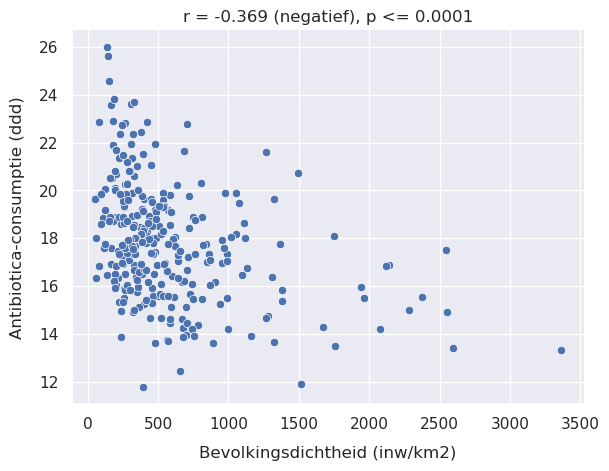

In [48]:
sns.set_theme()
tips = {
    "bevolkingsdichtheid": list_bevolkingsdichtheid,
    "ddd": list_antibiotica_consumptie
}
rp = sns.relplot(x=tips['bevolkingsdichtheid'], y=tips['ddd'])
rp.set_axis_labels("Bevolkingsdichtheid (inw/km2)", "Antibiotica-consumptie (ddd)", labelpad=10)
rp.figure.set_size_inches(6.5, 4.5)
plt.title(f"r = {format_r_value(r_value_scatterplot_antibiotica_bevolking)}, p {format_p_value(p_value_scatterplot_antibiotica_bevolking)}")
plt.show()

# Use Case 2: Scatterplot Percentage 65+ & Antibiotica Consumptie

## Data-Quality checks (onderlinge consistentie)

In [49]:
# Check of dezelfde gemeentes in beide data-sets aanwezig zijn
df_65plus_antibiotica_diff_gemeentes_65plus = spark_session.sql(f"select distinct(Gemeente) from percentage_65_plussers where Jaar = {JAAR_VERWERKING} \
                                                                  MINUS \
                                                                  select distinct(Gemeente) from antibiotica_consumptie where Jaar = {JAAR_VERWERKING}")
assert df_65plus_antibiotica_diff_gemeentes_65plus.count() == 0

# Todo: richting aanpassen
df_65plus_antibiotica_diff_gemeentes_antibiotica = spark_session.sql(f"select distinct(Gemeente) from antibiotica_consumptie where Jaar = {JAAR_VERWERKING} \
                                                                       MINUS \
                                                                       select distinct(Gemeente) from percentage_65_plussers where Jaar = {JAAR_VERWERKING}")
assert df_65plus_antibiotica_diff_gemeentes_antibiotica.count() == 0

## Afgeleide data van data-sets afbeelden

In [50]:
# Bepaal of het jaar gezamenlijk is tussen beide data-sets
df_65plus_antibiotica_65plus_gezamelijke_jaren = spark_session.sql(f"select distinct(Jaar) from percentage_65_plussers where Jaar = {JAAR_VERWERKING} \
                                                                     INTERSECT \
                                                                     select distinct(Jaar) from antibiotica_consumptie where Jaar = {JAAR_VERWERKING}")

print('Gezamenlijk jaar: ' + ','.join([str(item['Jaar']) for item in df_65plus_antibiotica_65plus_gezamelijke_jaren.collect()]))

Gezamenlijk jaar: 2021


## Controles op afgeleide-data

In [51]:
assert df_65plus_antibiotica_65plus_gezamelijke_jaren.count() == 1

## Data-Visualisatie

In [52]:
list_65plus = [row['Procent'] for row in spark_session.sql("select Procent from percentage_65_plussers order by Gemeente").collect()]
list_antibiotica = [row['Verhouding'] for row in spark_session.sql("select Verhouding from antibiotica_consumptie order by Gemeente").collect()]

In [53]:
pearson_correlation_scatterplot_antibiotica_65plus = pearsonr(list_antibiotica, list_65plus)
r_value_scatterplot_antibiotica_65plus = round(pearson_correlation_scatterplot_antibiotica_65plus[0], 3)
p_value_scatterplot_antibiotica_65plus = pearson_correlation_scatterplot_antibiotica_65plus[1]

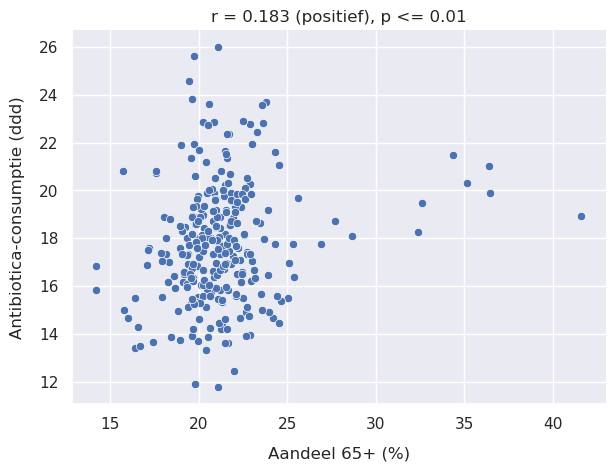

In [54]:
sns.set_theme()
tips = {
    "65plus": list_65plus,
    "ddd": list_antibiotica
}
rp = sns.relplot(x=tips['65plus'], y=tips['ddd'])
rp.set_axis_labels("Aandeel 65+ (%)", "Antibiotica-consumptie (ddd)", labelpad=10)
rp.figure.set_size_inches(6.5, 4.5)
plt.title(f"r = {format_r_value(r_value_scatterplot_antibiotica_65plus)}, p {format_p_value(p_value_scatterplot_antibiotica_65plus)}")
plt.show()

# Use Case 3: afbeelden bevolkingsdichtheid per gemeente

Hieronder wordt er een kaart van Vlaanderen afgebeeld die 1 dimensie weergeeft, nl. de bvolkingsdichtheid per gemeente.

In [55]:
df_kaartje_bevolkingsdichtheid_per_gemeente = df_cleaned_bevolkingsdichtheid.rdd.map(lambda r: [ r['Gemeente'], r['Dichtheid'] ])
toon_kaart_van_belgie(df_kaartje_bevolkingsdichtheid_per_gemeente.collect())